In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set(context="poster", style='whitegrid', font='sans-serif')

X_real = pkl.load(open('./data/X_processed.pkl', 'rb'))
y_real = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X_real.shape, y_real.shape)

output_dir = './output/'
public_dir = output_dir + 'acgan_500_0.0002_100'

# private directory for multiple epoch testing - p7
#private_dir = output_dir + 'p15_8.0_0.0001_500_0.002_100'
private_dir = '/media/brett/Drive/SPRINT_gan_output/p1_8.0_0.0001_500_0.002_100'

((6502, 3, 12), (6502,))


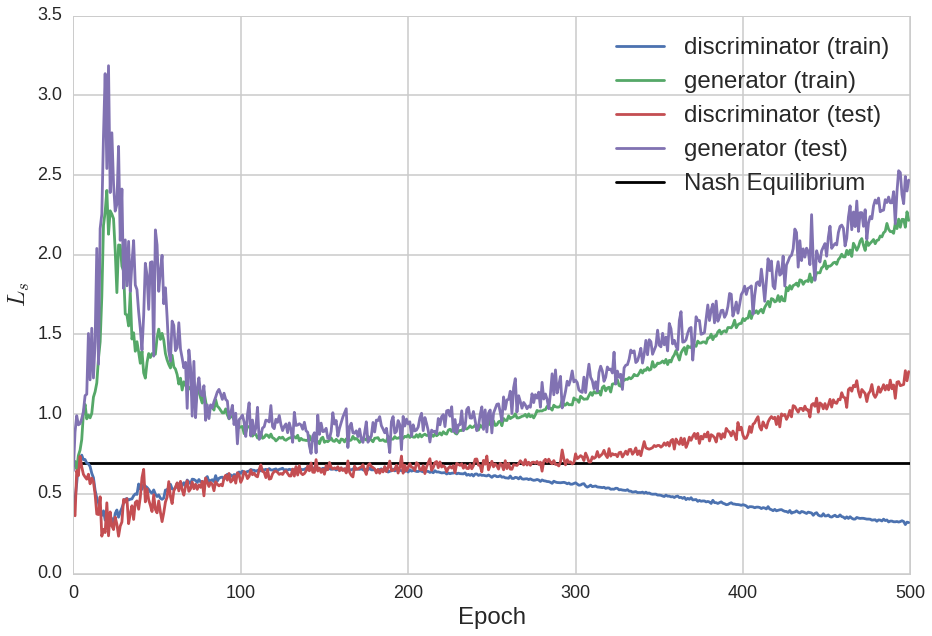

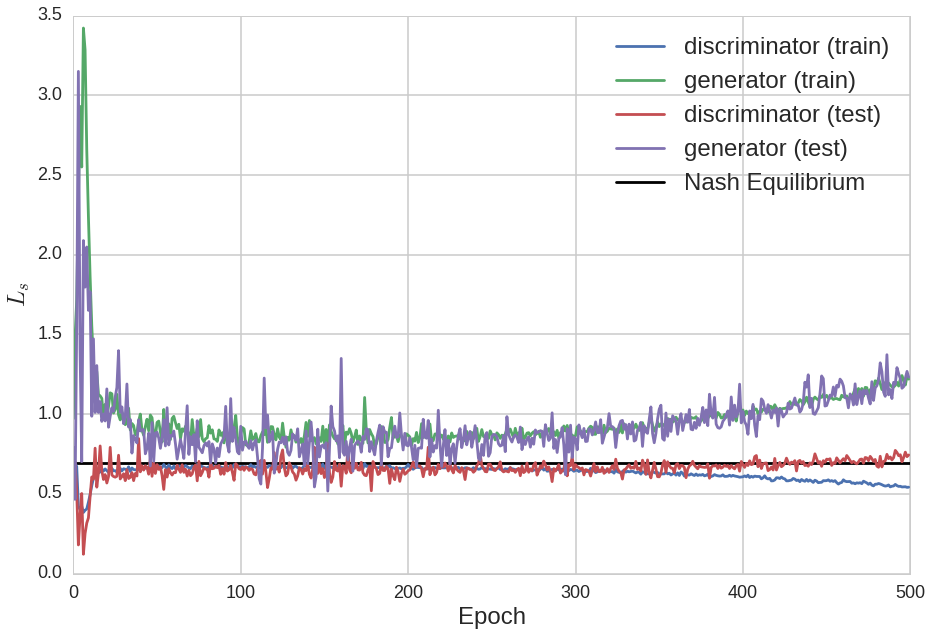

In [2]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(15,10))

hist = pkl.load(open(public_dir + '/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend(fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel(r'$L_s$',  fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()


plt.figure(figsize=(15,10))
hist = pkl.load(open(private_dir + '/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend(fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel(r'$L_s$', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [3]:
public_scores = pkl.load(open(public_dir + '/epoch_scores.p', 'rb'))
top_10_public = np.argsort(public_scores['rf'])[-5:]
top_10_lr = np.argsort(public_scores['lr'])[-5:]
top_10_public = np.concatenate([top_10_public, top_10_lr])
print(top_10_public)

[406 439 374 488 378 477 421 432 474 497]


In [4]:
np.random.seed(1)
# noisy selection
epoch_scores = pkl.load(open(private_dir + '/epoch_scores.p', 'rb'))

eps_per = 0.05
size = 500

top_5_rf = []
top_5_lr = []

for i in range(5):
    print(eps_per*size)
    noisy_epoch_scores_rf = (epoch_scores['rf'] + 
                             (np.random.laplace(loc=0.0,
                                                scale=(1/(eps_per*size)),
                                                size=500)))
    
    j=1
    while(np.argsort(noisy_epoch_scores_rf)[-j:][0] in top_5_rf):
        j += 1
    top_5_rf.append(np.argsort(noisy_epoch_scores_rf)[-j:][0])
    size = size - 1
    
    noisy_epoch_scores_lr = (epoch_scores['lr'] + 
                             (np.random.laplace(loc=0.0,
                                                scale=(1/(eps_per*size)),
                                                size=500)))
    k=1
    while(np.argsort(noisy_epoch_scores_lr)[-k:][0] in top_5_lr):
        k += 1
    top_5_lr.append(np.argsort(noisy_epoch_scores_lr)[-k:][0])
    size = size - 1


rf_noisy_scores = [epoch_scores['rf'][x] for x in top_5_rf]
lr_noisy_scores = [epoch_scores['lr'][x] for x in top_5_lr]
top_10 = np.concatenate([top_5_rf, top_5_lr])
print('top 10 ', top_10)
print(rf_noisy_scores, lr_noisy_scores)


rf_clean_scores = [epoch_scores['rf'][x] for x in np.argsort(epoch_scores['rf'])[-5:]]
lr_clean_scores = [epoch_scores['lr'][x] for x in np.argsort(epoch_scores['lr'])[-5:]]
print(rf_clean_scores, lr_clean_scores)

25.0
24.9
24.8
24.7
24.6
('top 10 ', array([251, 122, 204, 126, 172,  19,  12, 145,  71, 283]))
([0.84462151394422313, 0.88645418326693226, 0.82868525896414347, 0.88247011952191234, 0.85856573705179284], [0.69322709163346619, 0.69521912350597614, 0.62151394422310757, 0.70717131474103589, 0.70318725099601598])
([0.88047808764940239, 0.88247011952191234, 0.88645418326693226, 0.89043824701195218, 0.89043824701195218], [0.72908366533864544, 0.7310756972111554, 0.73705179282868527, 0.73705179282868527, 0.74701195219123506])


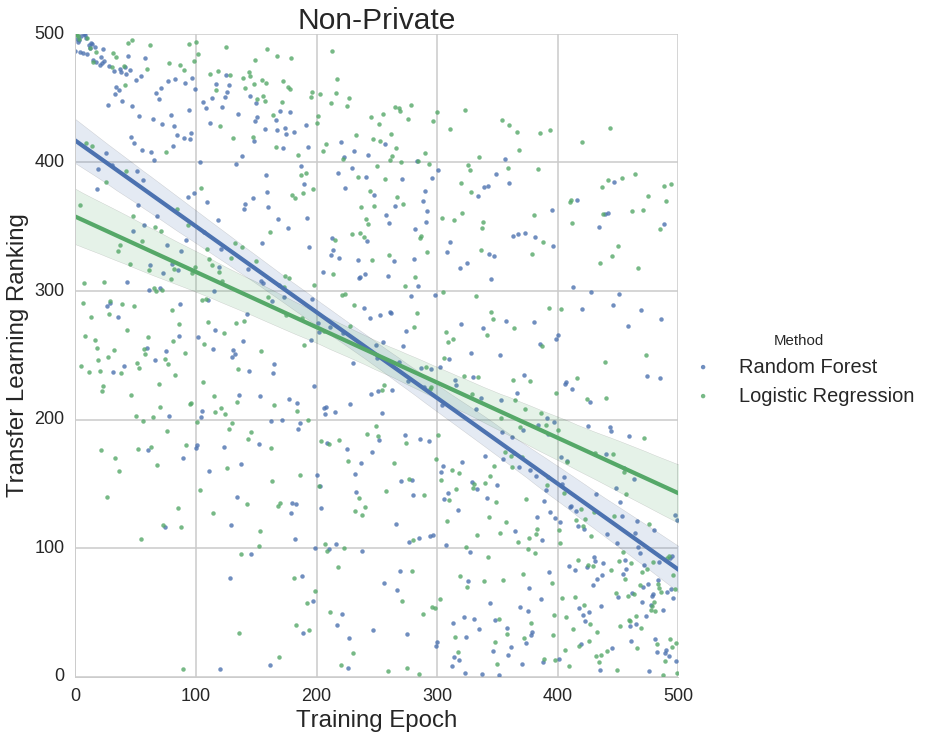

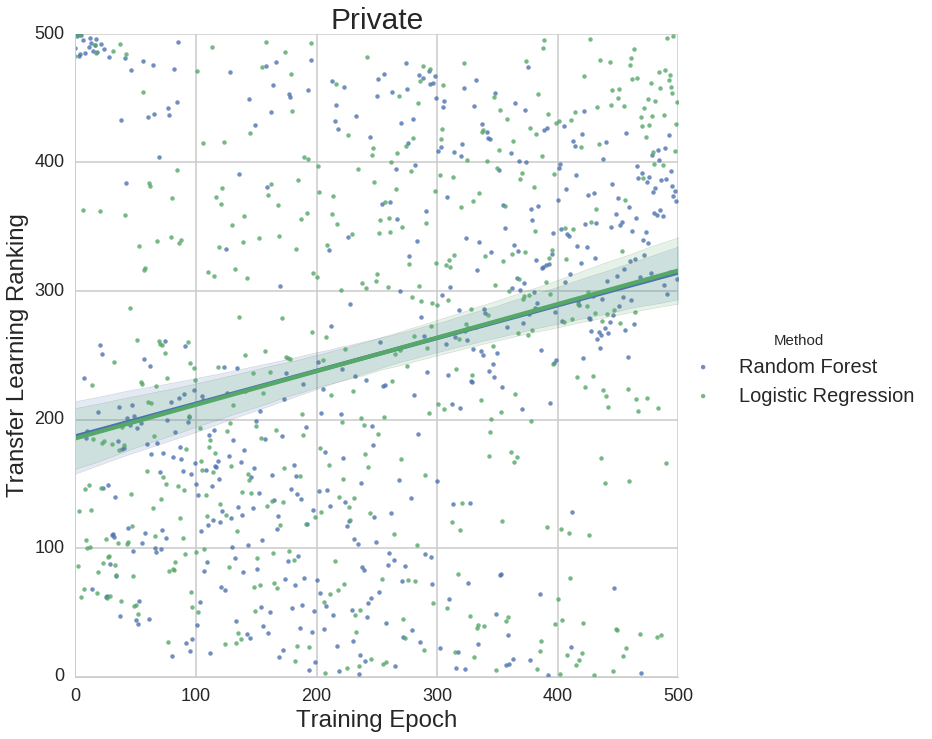

In [5]:
# plot public

params = {'legend.fontsize': 20}

plt.rcParams.update(params)
public = np.concatenate([500-np.argsort(public_scores['rf']), 500-np.argsort(public_scores['lr'])])
index = np.concatenate([range(500), range(500)])
method = np.concatenate([['Random Forest'] * 500, ['Logistic Regression'] * 500])

arg_scores = {'rank':public, 'index':index, 'Method':method}
arg_scores_df = pd.DataFrame.from_dict(arg_scores)

plt.figure(figsize=(6,4))
g = sns.lmplot(x="index", y="rank", hue="Method", data=arg_scores_df, size=10,
               y_jitter=.02, logistic=False, legend=True)
g.set(xlim=(0, 500), ylim=(0, 500))

plt.title('Non-Private', fontsize=30)
plt.xlabel('Training Epoch', fontsize=24)
plt.ylabel('Transfer Learning Ranking', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

# plot private
private = np.concatenate([500-np.argsort(epoch_scores['rf']), 500-np.argsort(epoch_scores['lr'])])
index = np.concatenate([range(500), range(500)])
method = np.concatenate([['Random Forest'] * 500, ['Logistic Regression'] * 500])

arg_scores = {'rank':private, 'index':index, 'Method':method}
arg_scores_df = pd.DataFrame.from_dict(arg_scores)

plt.figure(figsize=(6,4))
g = sns.lmplot(x="index", y="rank", hue="Method", data=arg_scores_df, size=10,
               y_jitter=.02, logistic=False, legend=True)
g.set(xlim=(0, 500), ylim=(0, 500))

plt.title('Private', fontsize=30)
plt.xlabel('Training Epoch', fontsize=24)
plt.ylabel('Transfer Learning Ranking', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

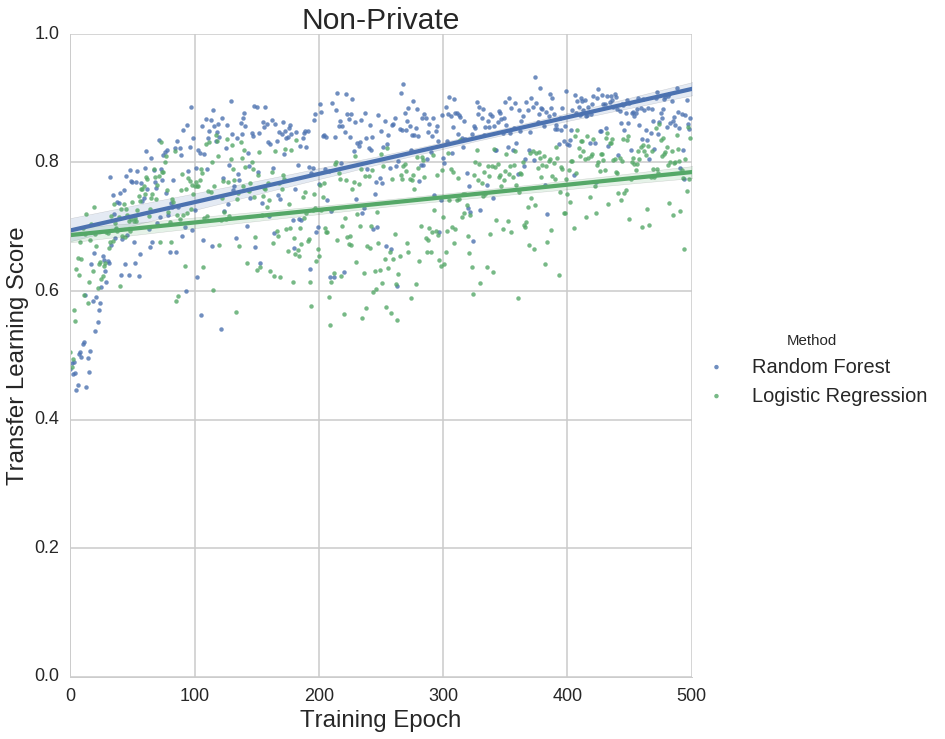

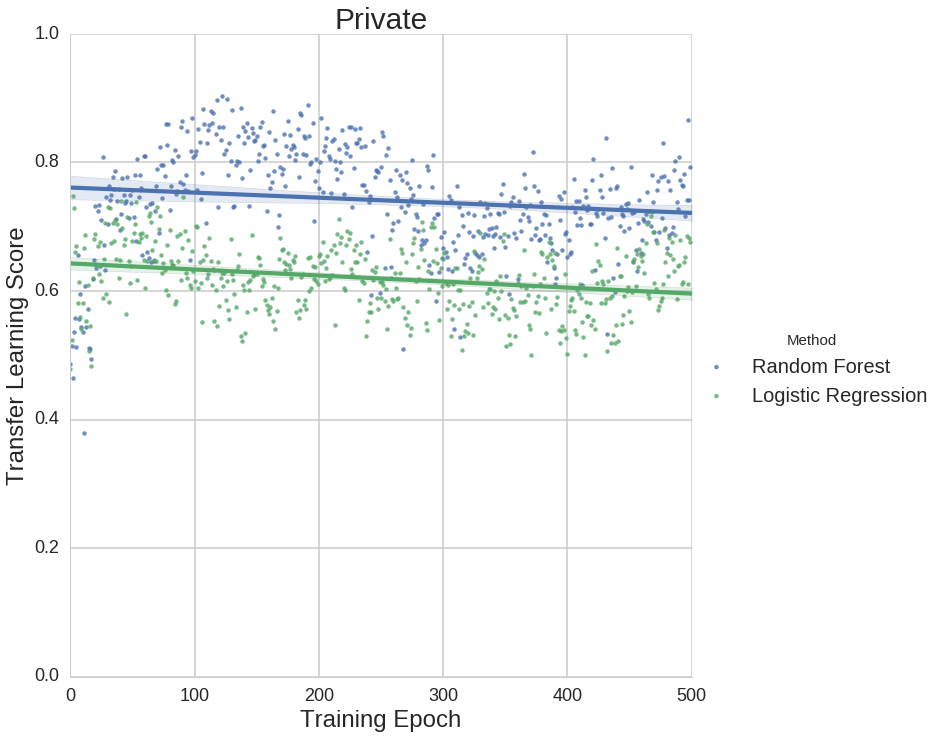

In [6]:
# plot public based on score instead of rank
params = {'legend.fontsize': 20}
plt.rcParams.update(params)
public = np.concatenate([public_scores['rf'], public_scores['lr']])
index = np.concatenate([range(500), range(500)])
method = np.concatenate([['Random Forest'] * 500, ['Logistic Regression'] * 500])

arg_scores = {'score':public, 'index':index, 'Method':method}
arg_scores_df = pd.DataFrame.from_dict(arg_scores)

plt.figure(figsize=(6,4))
g = sns.lmplot(x="index", y="score", hue="Method", data=arg_scores_df, size=10,
               y_jitter=.02, logistic=False, legend=True, legend_out=True)
g.set(xlim=(0, 500), ylim=(0, 1))

plt.title('Non-Private', fontsize=30)
plt.xlabel('Training Epoch', fontsize=24)
plt.ylabel('Transfer Learning Score', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

# plot private based on score instead of rank
private = np.concatenate([epoch_scores['rf'], epoch_scores['lr']])
index = np.concatenate([range(500), range(500)])
method = np.concatenate([['Random Forest'] * 500, ['Logistic Regression'] * 500])

arg_scores = {'score':private, 'index':index, 'Method':method}
arg_scores_df = pd.DataFrame.from_dict(arg_scores)

plt.figure(figsize=(6,4))
g = sns.lmplot(x="index", y="score", hue="Method", data=arg_scores_df, size=10,
               y_jitter=.02, logistic=False, legend=True, legend_out=True)
g.set(xlim=(0, 500), ylim=(0, 1))

plt.title('Private', fontsize=30)
plt.xlabel('Training Epoch', fontsize=24)
plt.ylabel('Transfer Learning Score', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.models import load_model

acgan = __import__('ac_gan')

generate_count = 5000
latent_size = 100

X_private = []
y_private = []

X_public = []
y_public = []

for i in range(len(top_10)):
    print(i)
    private_gen = load_model(private_dir + '/params_generator_epoch_' + "{0:0=3d}".format(top_10[i]) + '.h5')
    public_gen = load_model(public_dir + '/params_generator_epoch_' + "{0:0=3d}".format(top_10_public[i]) + '.h5')
    
    noise = np.random.uniform(-1, 1, (generate_count, latent_size))
    sampled_labels = np.random.randint(0, 2, generate_count)
    
    X_public.extend(public_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0))
    y_public.extend(sampled_labels)

    X_private.extend(private_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0))
    y_private.extend(sampled_labels)

X_private = np.array(X_private)
y_private = np.array(y_private)

X_public = np.array(X_public)
y_public = np.array(y_public)
print(X_private.shape, y_private.shape, X_public.shape, y_public.shape)

X_public = X_public.reshape(X_public.shape[0], X_public.shape[2], X_public.shape[3]).clip(min=0).astype('int')
X_private = X_private.reshape(X_private.shape[0], X_private.shape[2], X_private.shape[3]).clip(min=0).astype('int')
print(X_private.shape)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
0
1
2
3
4
5
6
7
8
9
((50000, 1, 3, 12), (50000,), (50000, 1, 3, 12), (50000,))
(50000, 3, 12)


In [8]:
epochs = 500 - 1

last_priv_gen = load_model(private_dir + '/params_generator_epoch_' + str(epochs) + '.h5')
last_public_gen = load_model(public_dir + '/params_generator_epoch_' + str(epochs) + '.h5')
noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)

last_X_private = last_priv_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)
last_X_public = last_public_gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

last_y_private = sampled_labels
last_y_public = sampled_labels

last_X_public = last_X_public.reshape(last_X_public.shape[0],
                                      last_X_public.shape[2],
                                      last_X_public.shape[3]).clip(min=0).astype('int')
last_X_private = last_X_private.reshape(last_X_private.shape[0],
                                        last_X_private.shape[2], 
                                        last_X_private.shape[3]).clip(min=0).astype('int')

In [9]:
real_split = 6000
X_train = X_real[:real_split]
X_test = X_real[real_split:]

y_train = y_real[:real_split]
y_test = y_real[real_split:]

print(X_private.shape)
print(X_real.shape)

stats_dict = {}
stats_dict['overall_mean_sp'] = [np.mean(X_train[:, 0, :]), np.mean(X_public[:, 0, :]), np.mean(X_private[:, 0, :])]
stats_dict['overall_mean_dp'] = [np.mean(X_train[:, 1, :]), np.mean(X_public[:, 1, :]), np.mean(X_private[:, 1, :])]
stats_dict['overall_mean_meds'] = [np.mean(X_train[:, 2, :]), np.mean(X_public[:, 2, :]), np.mean(X_private[:, 2, :])]

print(stats_dict)

(50000, 3, 12)
(6502, 3, 12)
{'overall_mean_dp': [72.023236111111117, 72.864900000000006, 71.03315666666667], 'overall_mean_meds': [2.2674861111111113, 2.0351149999999998, 1.837645], 'overall_mean_sp': [129.01034722222221, 128.95680333333334, 127.02407833333334]}


[[[145 124 117 136 145 144 144 167 120 113 128 117]
  [ 80  68  71  77  83  83  80  87  65  61  69  69]
  [  3   3   2   2   2   2   3   3   2   2   3   3]]

 [[138 154 137 131 147 137 139 140 169 142 146 135]
  [ 71  74  68  62  76  65  71  65  72  73  70  74]
  [  1   1   1   1   2   1   1   1   1   1   2   2]]

 [[123 133 126 139 117 150 132 142 145 127 139 151]
  [ 68  62  63  64  60  68  67  68  60  63  66  70]
  [  1   1   1   1   0   1   1   1   1   1   1   1]]]
((3236, 3, 12), (3266, 3, 12))
((24998, 3, 12), (25002, 3, 12))
((24998, 3, 12), (25002, 3, 12))


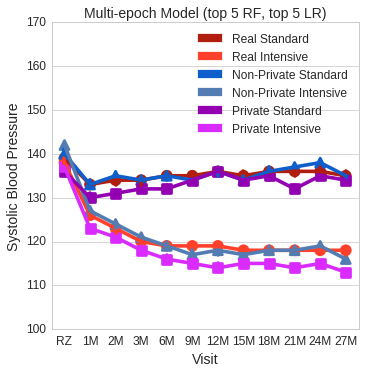

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592], [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]


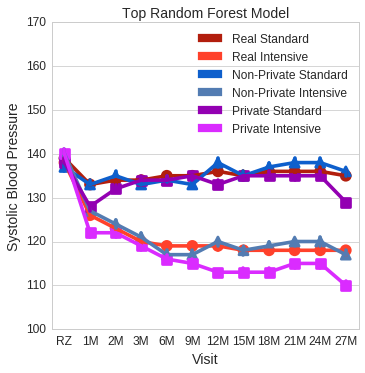

('Public ', (2565, 12), (2435, 12))
('Private ', (2565, 12), (2435, 12))
[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592], [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]


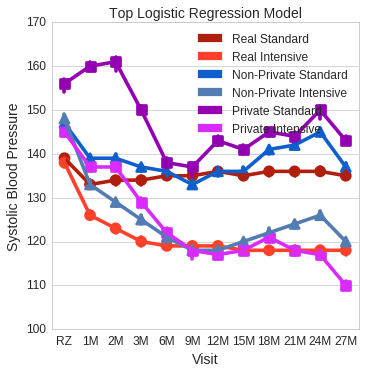

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592], [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]


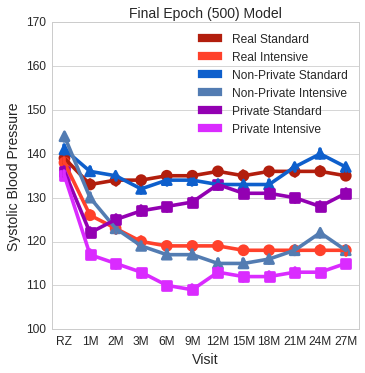

In [10]:
from numpy import median 
import matplotlib.patches as mpatches

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 20}                  
sns.set_context("paper", rc = paper_rc)    

markers = ['o', '^', 's']

standard_real = X_real[y_real==0] 
intensive_real = X_real[y_real==1]

standard_public = X_public[y_public==0] 
intensive_public = X_public[y_public==1]

standard_private = X_private[y_private==0] 
intensive_private = X_private[y_private==1]

print(standard_real[:3])
print(standard_real.shape, intensive_real.shape)
print(standard_public.shape, intensive_public.shape)
print(standard_private.shape, intensive_private.shape)

standard_real_sbp = standard_real[:, 0, :]
intensive_real_sbp = intensive_real[:, 0, :]

standard_public_sbp = standard_public[:, 0, :]
intensive_public_sbp =  intensive_public[:, 0, :]

standard_private_sbp = standard_private[:, 0, :]
intensive_private_sbp = intensive_private[:, 0, :]

colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(5.5, 5.5))
ax = sns.pointplot(data=standard_real_sbp, estimator=median, 
                   color=colors[0], label='Real Standard',
                   markers=markers[0])
ax = sns.pointplot(data=intensive_real_sbp, estimator=median,
                   color=colors[1], label='Real Intensive',
                   markers=markers[0])

ax = sns.pointplot(data=standard_public_sbp, estimator=median, 
                   color=colors[2], label='Non-Private Standard',
                   markers=markers[1])
ax = sns.pointplot(data=intensive_public_sbp, estimator=median, 
                   color=colors[3], label='Non-Private Intensive',
                   markers=markers[1])

ax = sns.pointplot(data=standard_private_sbp, estimator=median, 
                   color=colors[4], label='Private Standard',
                   markers=markers[2])
ax = sns.pointplot(data=intensive_private_sbp, estimator=median, 
                   color=colors[5], label='Private Intensive',
                   markers=markers[2])

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=12)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Multi-epoch Model (top 5 RF, top 5 LR)', fontsize=14)
plt.xlabel('Visit', fontsize=14)
plt.ylabel('Systolic Blood Pressure', fontsize=14)
plt.show()

# only top epoch rf
standard_public = X_public[:generate_count][y_public[:generate_count]==0] 
intensive_public = X_public[:generate_count][y_public[:generate_count]==1]

standard_private = X_private[:generate_count][y_private[:generate_count]==0] 
intensive_private = X_private[:generate_count][y_private[:generate_count]==1]

standard_real_sbp = standard_real[:generate_count, 0, :]
intensive_real_sbp = intensive_real[:generate_count, 0, :]

standard_public_sbp = standard_public[:generate_count, 0, :]
intensive_public_sbp =  intensive_public[:generate_count, 0, :]

standard_private_sbp = standard_private[:generate_count, 0, :]
intensive_private_sbp = intensive_private[:generate_count, 0, :]

print(sns.cubehelix_palette(n_colors=2, start=0))
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(5.5, 5.5))
ax = sns.pointplot(data=standard_real_sbp, estimator=median,
                   color=colors[0], label='Real Standard',
                   markers=markers[0])
ax = sns.pointplot(data=intensive_real_sbp, estimator=median,
                   color=colors[1], label='Real Intensive',
                   markers=markers[0])

ax = sns.pointplot(data=standard_public_sbp, estimator=median,
                   color=colors[2], label='Non-Private Standard', 
                   markers=markers[1])
ax = sns.pointplot(data=intensive_public_sbp, estimator=median,
                   color=colors[3], label='Non-Private Intensive', 
                   markers=markers[1])

ax = sns.pointplot(data=standard_private_sbp, estimator=median,
                   color=colors[4], label='Private Standard',
                   markers=markers[2])
ax = sns.pointplot(data=intensive_private_sbp, estimator=median,
                   color=colors[5], label='Private Intensive',
                   markers=markers[2])

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=12)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Top Random Forest Model', fontsize=14)
plt.xlabel('Visit', fontsize=14)
plt.ylabel('Systolic Blood Pressure', fontsize=14)
plt.show()

# only top feature lr
standard_real_sbp = standard_real[:, 0, :]
intensive_real_sbp = intensive_real[:, 0, :]

standard_public = X_public[(generate_count*5):(generate_count*6)][y_public[(generate_count*5):(generate_count*6)]==0] 
intensive_public = X_public[(generate_count*5):(generate_count*6)][y_public[(generate_count*5):(generate_count*6)]==1]

standard_private = X_private[(generate_count*5):(generate_count*6)][y_private[(generate_count*5):(generate_count*6)]==0] 
intensive_private = X_private[(generate_count*5):(generate_count*6)][y_private[(generate_count*5):(generate_count*6)]==1]

standard_public_sbp = standard_public[:generate_count, 0, :]
intensive_public_sbp =  intensive_public[:generate_count, 0, :]
print('Public ', standard_public_sbp.shape, intensive_public_sbp.shape)

standard_private_sbp = standard_private[:generate_count, 0, :]
intensive_private_sbp = intensive_private[:generate_count, 0, :]
print('Private ', standard_private_sbp.shape, intensive_private_sbp.shape)

print(sns.cubehelix_palette(n_colors=2, start=0))
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(5.5, 5.5))
ax = sns.pointplot(data=standard_real_sbp, estimator=median,
                   color=colors[0], label='Real Standard',
                   markers=markers[0])
ax = sns.pointplot(data=intensive_real_sbp, estimator=median,
                   color=colors[1], label='Real Intensive',
                   markers=markers[0])

ax = sns.pointplot(data=standard_public_sbp, estimator=median,
                   color=colors[2], label='Non-Private Standard',
                   markers=markers[1])
ax = sns.pointplot(data=intensive_public_sbp, estimator=median,
                   color=colors[3], label='Non-Private Intensive',
                   markers=markers[1])

ax = sns.pointplot(data=standard_private_sbp, estimator=median,
                   color=colors[4], label='Private Standard',
                   markers=markers[2])
ax = sns.pointplot(data=intensive_private_sbp, estimator=median,
                   color=colors[5], label='Private Intensive',
                   markers=markers[2])

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=12)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Top Logistic Regression Model', fontsize=14)
plt.xlabel('Visit', fontsize=14)
plt.ylabel('Systolic Blood Pressure', fontsize=14)
plt.show()

# only last epoch
standard_real = X_real[y_real==0] 
intensive_real = X_real[y_real==1]

standard_public = last_X_public[last_y_public==0] 
intensive_public = last_X_public[last_y_public==1]

standard_private = last_X_private[last_y_private==0] 
intensive_private = last_X_private[last_y_private==1]

standard_real_sbp = standard_real[:, 0, :]
intensive_real_sbp = intensive_real[:, 0, :]

standard_public_sbp = standard_public[:generate_count, 0, :]
intensive_public_sbp =  intensive_public[:generate_count, 0, :]

standard_private_sbp = standard_private[:generate_count, 0, :]
intensive_private_sbp = intensive_private[:generate_count, 0, :]

print(sns.cubehelix_palette(n_colors=2, start=0))
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1M', '2M', '3M', '6M', '9M', '12M', '15M',
               '18M', '21M', '24M', '27M']

plt.figure(figsize=(5.5, 5.5))
ax = sns.pointplot(data=standard_real_sbp, estimator=median,
                   color=colors[0], label='Real Standard',
                   markers=markers[0])
ax = sns.pointplot(data=intensive_real_sbp, estimator=median,
                   color=colors[1], label='Real Intensive',
                   markers=markers[0])

ax = sns.pointplot(data=standard_public_sbp, estimator=median,
                   color=colors[2], label='Non-Private Standard',
                   markers=markers[1])
ax = sns.pointplot(data=intensive_public_sbp, estimator=median,
                   color=colors[3], label='Non-Private Intensive',
                   markers=markers[1])

ax = sns.pointplot(data=standard_private_sbp, estimator=median,
                   color=colors[4], label='Private Standard', 
                   markers=markers[2])
ax = sns.pointplot(data=intensive_private_sbp, estimator=median,
                   color=colors[5], label='Private Intensive', 
                   markers=markers[2])

real_standard_patch = mpatches.Patch(color=colors[0], label='Real Standard')
real_intensive_patch = mpatches.Patch(color=colors[1], label='Real Intensive')
public_standard_patch = mpatches.Patch(color=colors[2], label='Non-Private Standard')
public_intensive_patch = mpatches.Patch(color=colors[3], label='Non-Private Intensive')
private_standard_patch = mpatches.Patch(color=colors[4], label='Private Standard')
private_intensive_patch = mpatches.Patch(color=colors[5], label='Private Intensive')

ax.legend(handles=[real_standard_patch, real_intensive_patch, public_standard_patch, public_intensive_patch,
                   private_standard_patch, private_intensive_patch],
          fontsize=12)
ax.set_ylim([100, 170])
ax.set_xticklabels(visit_codes)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Final Epoch (500) Model', fontsize=14)
plt.xlabel('Visit', fontsize=14)
plt.ylabel('Systolic Blood Pressure', fontsize=14)
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import neighbors

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# add neural network

scores = {'real_rf':[], 'public_rf':[], 'private_rf':[],
          'real_linear':[], 'public_linear':[], 'private_linear':[], 
          'real_svm': [], 'public_svm': [], 'private_svm': [],
          'real_nn': [], 'public_nn': [], 'private_nn': []}
full_scores = {}

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_real = X_real.reshape(X_real.shape[0], -1)
X_public = X_public.reshape(X_public.shape[0], -1)
X_private = X_private.reshape(X_private.shape[0], -1)

print(X_train.shape, X_test.shape, X_real.shape, X_public.shape, X_private.shape)
print(y_train.shape, y_test.shape)

rf_clf = RandomForestClassifier(random_state=0)
nn_clf = neighbors.KNeighborsClassifier()
svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
lr_clf = linear_model.LogisticRegression(random_state=0)

full_real_rf_clf = RandomForestClassifier(random_state=0)
full_real_nn_clf = neighbors.KNeighborsClassifier()
full_real_svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
full_real_lr_clf = linear_model.LogisticRegression(random_state=0)

full_public_rf_clf = RandomForestClassifier(random_state=0)
full_public_nn_clf = neighbors.KNeighborsClassifier()
full_public_svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
full_public_lr_clf = linear_model.LogisticRegression(random_state=0)

full_private_rf_clf = RandomForestClassifier(random_state=0)
full_private_nn_clf = neighbors.KNeighborsClassifier()
full_private_svm_clf = SVC(C=1.0, kernel='linear', random_state=0)
full_private_lr_clf = linear_model.LogisticRegression(random_state=0)

((6000, 36), (502, 36), (6502, 36), (50000, 36), (50000, 36))
((6000,), (502,))


In [12]:
for i in range(10):
    print(i)
    start = i * generate_count
    stop = (i+1) * generate_count
    
    # Random forest
    real_y_pred = rf_clf.fit(X_train, y_train).predict(X_test)
    scores['real_rf'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = rf_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_rf'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = rf_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_rf'].append(accuracy_score(y_test, private_y_pred))

    # Nearest Neighbors
    real_y_pred = nn_clf.fit(X_train, y_train).predict(X_test)
    scores['real_nn'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = nn_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_nn'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = nn_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_nn'].append(accuracy_score(y_test, private_y_pred))

    # SVM
    real_y_pred = svm_clf.fit(X_train, y_train).predict(X_test)
    scores['real_svm'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = svm_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_svm'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = svm_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_svm'].append(accuracy_score(y_test, private_y_pred))

    # Logistic Regression
    real_y_pred = lr_clf.fit(X_train, y_train).predict(X_test)
    scores['real_linear'].append(accuracy_score(y_test, real_y_pred))

    public_y_pred = lr_clf.fit(X_public[start:stop], y_public[start:stop]).predict(X_test)
    scores['public_linear'].append(accuracy_score(y_test, public_y_pred))

    private_y_pred = lr_clf.fit(X_private[start:stop], y_private[start:stop]).predict(X_test)
    scores['private_linear'].append(accuracy_score(y_test, private_y_pred))
        
print(scores)

0
1
2
3
4
5
6
7
8
9
{'real_rf': [0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143, 0.92629482071713143], 'private_nn': [0.84262948207171318, 0.56374501992031878, 0.87051792828685259, 0.84661354581673309, 0.85059760956175301, 0.7310756972111554, 0.55776892430278879, 0.88047808764940239, 0.84661354581673309, 0.86454183266932272], 'public_linear': [0.82470119521912355, 0.8027888446215139, 0.73505976095617531, 0.82470119521912355, 0.8027888446215139, 0.83466135458167334, 0.82868525896414347, 0.84860557768924305, 0.83067729083665343, 0.84462151394422313], 'public_rf': [0.89442231075697209, 0.89442231075697209, 0.90239043824701193, 0.9083665338645418, 0.91035856573705176, 0.88844621513944222, 0.8844621513944223, 0.89641434262948205, 0.88247011952191234, 0.89243027888446214], 'public_nn': [0.87450199203187251, 0.83067729083665343, 0.84860557768924305, 0.85

In [13]:
real_y_pred = full_real_rf_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_rf'] = (accuracy_score(y_test, real_y_pred))

public_y_pred = full_public_rf_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_rf'] = (accuracy_score(y_test, public_y_pred))

private_y_pred = full_private_rf_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_rf'] = (accuracy_score(y_test, private_y_pred))

# Nearest Neighbors
real_y_pred = full_real_nn_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_nn'] = (accuracy_score(y_test, real_y_pred))

public_y_pred = full_public_nn_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_nn'] = (accuracy_score(y_test, public_y_pred))

private_y_pred = nn_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_nn'] = (accuracy_score(y_test, private_y_pred))

# SVM
real_y_pred = full_real_svm_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_svm'] = (accuracy_score(y_test, real_y_pred))

public_y_pred = full_public_svm_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_svm'] = (accuracy_score(y_test, public_y_pred))

private_y_pred = full_private_svm_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_svm'] = (accuracy_score(y_test, private_y_pred))

# Logistic Regression
real_y_pred = full_real_lr_clf.fit(X_train, y_train).predict(X_test)
full_scores['real_linear'] = (accuracy_score(y_test, real_y_pred))

public_y_pred = full_public_lr_clf.fit(X_public, y_public).predict(X_test)
full_scores['public_linear'] = (accuracy_score(y_test, public_y_pred))

private_y_pred = full_private_lr_clf.fit(X_private, y_private).predict(X_test)
full_scores['private_linear'] = (accuracy_score(y_test, private_y_pred))
print(full_scores)

{'real_rf': 0.92629482071713143, 'private_nn': 0.83864541832669326, 'public_linear': 0.89043824701195218, 'public_rf': 0.9083665338645418, 'public_nn': 0.8605577689243028, 'real_nn': 0.87450199203187251, 'public_svm': 0.91235059760956172, 'private_linear': 0.8366533864541833, 'private_rf': 0.89243027888446214, 'real_svm': 0.93625498007968122, 'private_svm': 0.84063745019920322, 'real_linear': 0.93426294820717126}


In [14]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 40,
          'axes.titlesize':'x-large',
          'xtick.labelsize':15,
          'ytick.labelsize':15,
          'legend.edgecolor': 'black'}
pylab.rcParams.update(params)

# plt.figure(figsize=(20, 20))
# plt.ylabel('Test Accuracy')
# plt.xlabel('Training Data')

transfer_scores = pd.DataFrame.from_dict(scores, orient='index')
print(transfer_scores)

full_scores_df = pd.DataFrame.from_dict(data=full_scores, orient='index')
full_scores_df.columns = ['Score']
#full_scores_df['rf'] = 
#print(full_scores_df)


                       0         1         2         3         4         5  \
real_rf         0.926295  0.926295  0.926295  0.926295  0.926295  0.926295   
private_nn      0.842629  0.563745  0.870518  0.846614  0.850598  0.731076   
public_linear   0.824701  0.802789  0.735060  0.824701  0.802789  0.834661   
public_rf       0.894422  0.894422  0.902390  0.908367  0.910359  0.888446   
public_nn       0.874502  0.830677  0.848606  0.852590  0.834661  0.872510   
private_linear  0.790837  0.727092  0.812749  0.695219  0.729084  0.649402   
private_rf      0.902390  0.741036  0.884462  0.760956  0.862550  0.731076   
real_svm        0.936255  0.936255  0.936255  0.936255  0.936255  0.936255   
private_svm     0.858566  0.703187  0.912351  0.866534  0.892430  0.780876   
real_nn         0.874502  0.874502  0.874502  0.874502  0.874502  0.874502   
public_svm      0.892430  0.894422  0.904382  0.914343  0.882470  0.892430   
real_linear     0.934263  0.934263  0.934263  0.934263  0.934263

0.926294820717


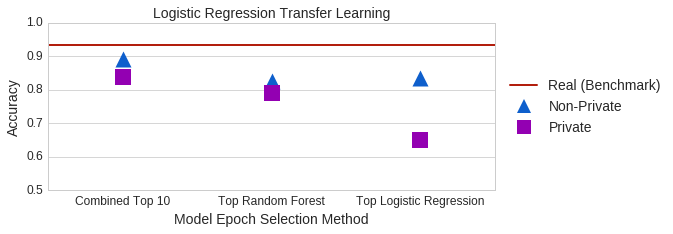

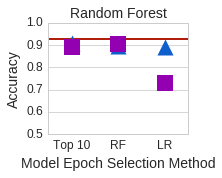

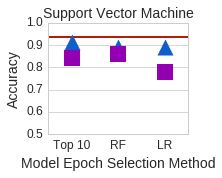

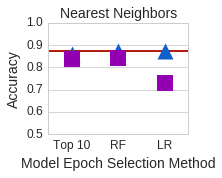

In [15]:
import matplotlib.lines as mlines

full_scores_df = pd.DataFrame.from_dict(data=full_scores, orient='index')
full_scores_df.columns = ['Score']
full_scores_df['models'] = ['combined'] * 12
# full_scores_df.loc[full_scores_df['real_rf'], 'method'] = 'Real'
full_scores_df.loc[['real_rf', 'real_nn', 'real_svm', 'real_linear'], 'method'] = 'Real'
full_scores_df.loc[['public_rf', 'real_nn', 'real_svm', 'real_linear'], 'privacy'] = 'Real'

score_df_rf = transfer_scores[0]
#score_df_rf['real_rf']['method'] = 'Real'
score_df_rf = pd.DataFrame(score_df_rf)
score_df_rf.columns = ['Score']
score_df_rf['models'] = ['top_rf'] * 12
score_df_rf.drop(['real_rf', 'real_nn', 'real_svm', 'real_linear'], inplace=True)

score_df_lr = transfer_scores[5]
score_df_lr = pd.DataFrame(score_df_lr)
score_df_lr.columns = ['Score']
score_df_lr['models'] = ['top_lr'] * 12
score_df_lr.drop(['real_rf', 'real_nn', 'real_svm', 'real_linear'], inplace=True)
full_scores_df = full_scores_df.append(score_df_rf).append(score_df_lr)

full_scores_df['privacy'] = [d.split('_')[0] for d in full_scores_df.index]
full_scores_df = pd.concat([full_scores_df, pd.get_dummies(full_scores_df['privacy'])], axis=1)
full_scores_df['meth_group'] = [d.split('_')[1] for d in full_scores_df.index] #.split('_')
full_scores_df = pd.concat([full_scores_df, pd.get_dummies(full_scores_df['meth_group'])], axis=1)

real_rf_score = full_scores_df.loc['real_rf']['Score']
real_lr_score = full_scores_df.loc['real_linear']['Score']
real_svm_score = full_scores_df.loc['real_svm']['Score']
real_nn_score = full_scores_df.loc['real_nn']['Score']
print(real_rf_score)


plt.figure(figsize=(8, 3))
df = full_scores_df
# rf_df = df.loc[(df['meth_group'] == 'rf') & ((df['private'] == 1.0) | df['public'] == 1.0)]
private_lr = df.loc[(df['meth_group'] == 'linear') & (df['private'] == 1.0)]
public_lr = df.loc[(df['meth_group'] == 'linear') & (df['public'] == 1.0)]

m = sns.stripplot(data=public_lr, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[1], split=True,
                  palette=[colors[2]])
n = sns.stripplot(data=private_lr, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[2], split=True,
                  palette=[colors[4]])

real_patch = mlines.Line2D([], [], color=colors[0],
              label='Real (Benchmark)')
public_patch =  mlines.Line2D([], [], marker=markers[1], 
                              markersize=14, linewidth=0, color=colors[2])
private_patch = mlines.Line2D([], [], marker=markers[2], 
                              markersize=14, linewidth=0, color=colors[4])

methods = ["Combined Top 10", "Top Random Forest", "Top Logistic Regression"]
n.set_xticklabels(methods)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Logistic Regression Transfer Learning', fontsize=14)
plt.ylim([0.5, 1])
plt.xlabel('Model Epoch Selection Method', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.legend(handles=[real_patch, public_patch, private_patch],
           labels=['Real (Benchmark)', 'Non-Private', 'Private'],
           loc='right', ncol=1,
           bbox_to_anchor=(1.4, 0.5), fancybox=True)
plt.plot(np.linspace(-20,120,1000), [real_lr_score]*1000, colors[0])

methods = ["Top 10", "RF", "LR"]
plt.figure(figsize=(2.5,2))
private_rf = df.loc[(df['meth_group'] == 'rf') & (df['private'] == 1.0)]
public_rf = df.loc[(df['meth_group'] == 'rf') & (df['public'] == 1.0)]

m = sns.stripplot(data=public_rf, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[1], split=True,
                  palette=[colors[2]])
n = sns.stripplot(data=private_rf, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[2], split=True,
                  palette=[colors[4]])
n.set_xticklabels(methods)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Random Forest', fontsize=14)
plt.ylim([0.5, 1])
plt.xlabel('Model Epoch Selection Method', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
n.legend_.remove()
plt.plot(np.linspace(-20,120,1000), [real_rf_score]*1000, colors[0])

plt.figure(figsize=(2.5,2))
private_svm = df.loc[(df['meth_group'] == 'svm') & (df['private'] == 1.0)]
public_svm = df.loc[(df['meth_group'] == 'svm') & (df['public'] == 1.0)]

m = sns.stripplot(data=public_svm, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[1], split=True,
                  palette=[colors[2]])
n = sns.stripplot(data=private_svm, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[2], split=True,
                  palette=[colors[4]])

n.set_xticklabels(methods)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Support Vector Machine', fontsize=14)
plt.ylim([0.5, 1])
plt.xlabel('Model Epoch Selection Method', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
n.legend_.remove()
plt.plot(np.linspace(-20,120,1000), [real_svm_score]*1000, colors[0])

plt.figure(figsize=(2.5,2))
private_nn = df.loc[(df['meth_group'] == 'nn') & (df['private'] == 1.0)]
public_nn = df.loc[(df['meth_group'] == 'nn') & (df['public'] == 1.0)]

m = sns.stripplot(data=public_nn, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[1], split=True,
                  palette=[colors[2]])
n = sns.stripplot(data=private_nn, y="Score", x="models",
                  hue="privacy", size=16, marker=markers[2], split=True,
                  palette=[colors[4]])

n.set_xticklabels(methods)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Nearest Neighbors', fontsize=14)
plt.ylim([0.5, 1])
plt.xlabel('Model Epoch Selection Method', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
n.legend_.remove()
plt.plot(np.linspace(-20,120,1000), [real_nn_score]*1000, colors[0])

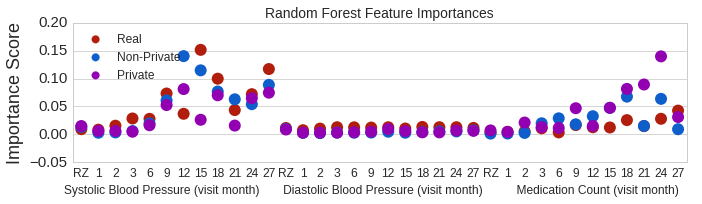

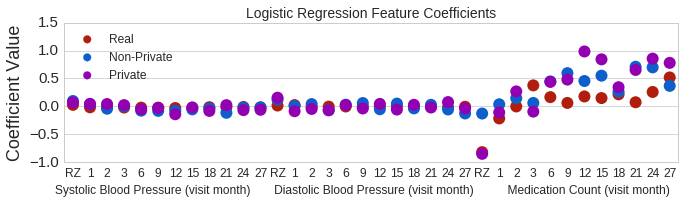

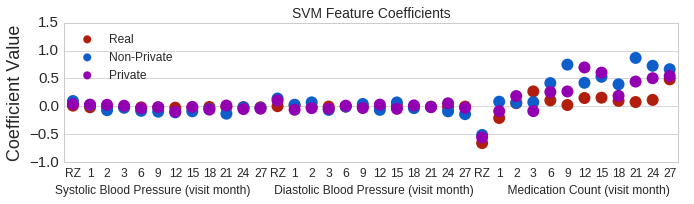

In [16]:
colors = ['#B21E0D', '#FF412B', '#0E5FCC', '#537CB2', '#9300B2', '#DA2BFF']
visit_codes = ['RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27',
               'RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27',
               'RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27']

importances = {'method': [], 'variable': [], 'importance': []}

real_rf_importances = full_real_rf_clf.feature_importances_
public_rf_importances = full_public_rf_clf.feature_importances_
private_rf_importances = full_private_rf_clf.feature_importances_

for i in range(len(real_rf_importances)):
    importances['method'].append('Real')
    importances['variable'].append(i)
    importances['importance'].append(real_rf_importances[i])
    importances['method'].append('Non-Private')
    importances['variable'].append(i)
    importances['importance'].append(public_rf_importances[i])
    importances['method'].append('Private')
    importances['variable'].append(i)
    importances['importance'].append(private_rf_importances[i])

plt.figure(figsize=(11, 2.5))
importance_df = pd.DataFrame.from_dict(importances)
ax = sns.stripplot(x="variable", y="importance", hue="method",
                   data=importance_df, palette=[colors[0], colors[2], colors[4]], size=12)
plt.title("Random Forest Feature Importances")
ax.set_xticklabels(visit_codes, fontsize=12)
plt.ylabel('Importance Score', fontsize=18)
plt.xlabel('Systolic Blood Pressure (visit month)       Diastolic Blood Pressure (visit month)          Medication Count (visit month)     ',
           fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()


coefs = {'method': [], 'variable': [], 'importance': []}
real_lr_coefs = full_real_lr_clf.coef_[0]
public_lr_coefs = full_public_lr_clf.coef_[0]
private_lr_coefs = full_private_lr_clf.coef_[0]

for i in range(len(real_lr_coefs)):
    coefs['method'].append('Real')
    coefs['variable'].append(i)
    coefs['importance'].append(real_lr_coefs[i])
    coefs['method'].append('Non-Private')
    coefs['variable'].append(i)
    coefs['importance'].append(public_lr_coefs[i])
    coefs['method'].append('Private')
    coefs['variable'].append(i)
    coefs['importance'].append(private_lr_coefs[i])
    
plt.figure(figsize=(11, 2.5))
importance_df = pd.DataFrame.from_dict(coefs)
ax = sns.stripplot(x="variable", y="importance", hue="method",
              data=importance_df, palette=[colors[0], colors[2], colors[4]], size=12)
plt.title("Logistic Regression Feature Coefficients")
ax.set_xticklabels(visit_codes, fontsize=12)
plt.ylabel('Coefficient Value', fontsize=18)
plt.xlabel('Systolic Blood Pressure (visit month)       Diastolic Blood Pressure (visit month)          Medication Count (visit month)     ',
           fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

coefs = {'method': [], 'variable': [], 'importance': []}
real_svm_coefs = full_real_svm_clf.coef_[0]
public_svm_coefs = full_public_svm_clf.coef_[0]
private_svm_coefs = full_private_svm_clf.coef_[0]

for i in range(len(real_svm_coefs)):
    coefs['method'].append('Real')
    coefs['variable'].append(i)
    coefs['importance'].append(real_svm_coefs[i])
    coefs['method'].append('Non-Private')
    coefs['variable'].append(i)
    coefs['importance'].append(public_svm_coefs[i])
    coefs['method'].append('Private')
    coefs['variable'].append(i)
    coefs['importance'].append(private_svm_coefs[i])
    
plt.figure(figsize=(11, 2.5))
importance_df = pd.DataFrame.from_dict(coefs)
ax = sns.stripplot(x="variable", y="importance", hue="method",
              data=importance_df, palette=[colors[0], colors[2], colors[4]], size=12)
plt.title("SVM Feature Coefficients")
ax.set_xticklabels(visit_codes, fontsize=12)
plt.ylabel('Coefficient Value', fontsize=18)
plt.xlabel('Systolic Blood Pressure (visit month)       Diastolic Blood Pressure (visit month)          Medication Count (visit month)     ',
           fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()


In [17]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

# rf_real_list = real_rf_importances.argsort().argsort()
# rf_public_list = public_rf_importances.argsort().argsort()
# rf_private_list = private_rf_importances.argsort().argsort()

# print(real_rf_importances, public_rf_importances, private_rf_importances)
# print(rf_real_list, rf_public_list, rf_private_list)

print('RF')
print(spearmanr(real_rf_importances, public_rf_importances))
print(spearmanr(real_rf_importances, private_rf_importances))
print(spearmanr(public_rf_importances, private_rf_importances))

# print('List')
# print(spearmanr(rf_real_list, rf_public_list))
# print(spearmanr(rf_real_list, rf_private_list))
# print(spearmanr(rf_public_list, rf_private_list))

print('SVM')
print(spearmanr(real_svm_coefs, public_svm_coefs))
print(spearmanr(real_svm_coefs, private_svm_coefs))
print(spearmanr(public_svm_coefs, private_svm_coefs))

print('LR')
print(spearmanr(real_lr_coefs, public_lr_coefs))
print(spearmanr(real_lr_coefs, private_lr_coefs))
print(spearmanr(public_lr_coefs, private_lr_coefs))


RF
SpearmanrResult(correlation=0.72149292149292166, pvalue=6.8686352364763236e-07)
SpearmanrResult(correlation=0.5541827541827542, pvalue=0.00045344584467654265)
SpearmanrResult(correlation=0.7974259974259974, pvalue=5.8296286729318626e-09)
SVM
SpearmanrResult(correlation=0.76010296010296008, pvalue=7.5557040975304102e-08)
SpearmanrResult(correlation=0.57657657657657657, pvalue=0.00023271952515838232)
SpearmanrResult(correlation=0.56833976833976829, pvalue=0.00029908841612465685)
LR
SpearmanrResult(correlation=0.77606177606177607, pvalue=2.6818177000455792e-08)
SpearmanrResult(correlation=0.59922779922779912, pvalue=0.00011264050650240467)
SpearmanrResult(correlation=0.65637065637065639, pvalue=1.3814044535839118e-05)


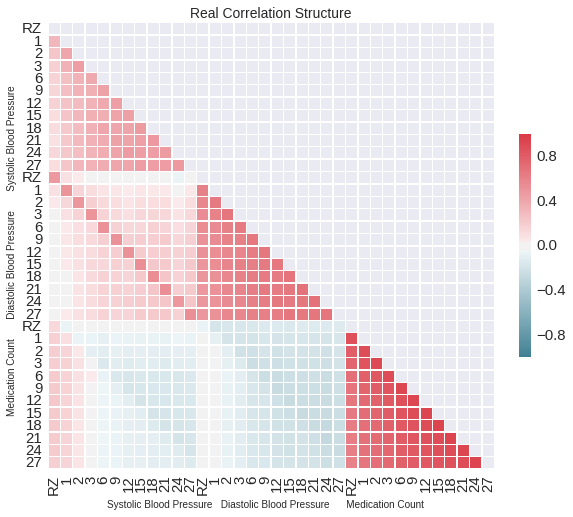

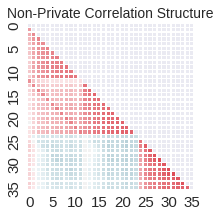

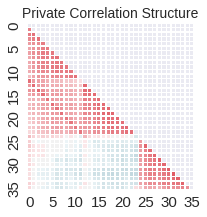

In [18]:
from matplotlib import gridspec

sns.set_style('darkgrid')

visit_codes = ['RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27',
               'RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27',
               'RZ', '1', '2', '3', '6', '9', '12', '15', '18', '21', '24', '27']

d = pd.DataFrame(X_train)
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(9, 8))
ax0 = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=visit_codes, yticklabels=visit_codes,
            linewidths=.5, cbar=1, cbar_kws={"fraction": 0.05,
                                             "shrink": 0.5,
                                             "orientation": "vertical"})
ax0.set_title("Real Correlation Structure")
ax0.set_xlabel('Systolic Blood Pressure   Diastolic Blood Pressure      Medication Count    ',
                 fontsize=10)
ax0.set_ylabel('Medication Count       Diastolic Blood Pressure       Systolic Blood Pressure   ',
                 fontsize=10)
plt.show()

plt.figure(figsize=(3, 3))
d = pd.DataFrame(X_public)
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar=0, cbar_kws={"orientation": "horizontal"})
ax1.set_title("Non-Private Correlation Structure")
plt.show()
# ax1.set_xlabel('Systolic Blood Pressure   Diastolic Blood Pressure      Medication Count    ',
#                  fontsize=10)
# ax1.set_ylabel('Medication Count       Diastolic Blood Pressure       Systolic Blood Pressure   ',
#                  fontsize=10)

plt.figure(figsize=(3, 3))
d = pd.DataFrame(X_private)
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax2 = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar=0, cbar_kws={"orientation": "horizontal"})
ax2.set_title("Private Correlation Structure")
# ax2.set_xlabel('Systolic Blood Pressure   Diastolic Blood Pressure      Medication Count    ',
#                  fontsize=10)
# ax2.set_ylabel('Medication Count       Diastolic Blood Pressure       Systolic Blood Pressure   ',
#                 fontsize=10)
sns.set_style('whitegrid')
plt.show()

In [19]:
# privacy analysis
hist = pkl.load(open(private_dir + '/acgan-history.pkl', 'rb'))

hist_list = []
batch = 0
epoch = 1

for p in hist['privacy']:
    if batch == 0:
        for ed in p:
            if ed[0] < 4:
                hist_list.append({'Epoch': 0, 'eps': ed[0], 'delta': 0})
    elif batch % 60 == 0:
        for ed in p:
            if ed[0] < 4:
                hist_list.append({'Epoch': epoch, 'eps': ed[0], 'delta': ed[1]})
        epoch += 1
    batch += 1
print(len(hist_list))
print(batch)

2500
30000


   Epoch  delta    eps
0      0    0.0  0.125
1      0    0.0  0.250
2      0    0.0  0.500
3      0    0.0  1.000
4      0    0.0  2.000


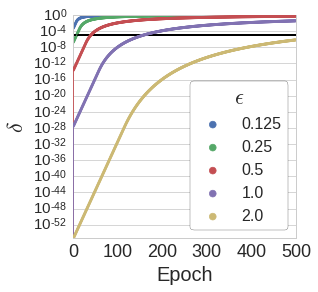

In [20]:
hist_df = pd.DataFrame(hist_list)
print(hist_df.head())

plt.figure(figsize=(4, 4))
ax = sns.pointplot(data=hist_df, x='Epoch', y='delta', hue='eps', scale=0.25)

ax.set(yscale="log")
ax.set_ylim([0, 1])
ax.set_ylabel(r'$\delta$', fontsize=22)
ax.set_xlabel('Epoch', fontsize=20)
legend = ax.legend(loc='best', fontsize=16, markerscale=3, frameon=True, fancybox=True)
legend.set_title(r'$\epsilon$', prop={'size': 22})

plt.xticks(np.arange(0, 500+1, 100))
ax.set_xticklabels([0, 100, 200, 300, 400, 500], fontsize=18)

plt.hlines(1*10**-5, 0, 500, label='Delta Max')
plt.show()

(6000, 36)
(6000, 2)
2
[ 0.32102973  0.16801213]
(56000, 36)


/home/brett/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 56000 but corresponding boolean dimension is 12000


[ 0.44795022  0.14954554]
(56000, 36)


/home/brett/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 56000 but corresponding boolean dimension is 11000


[ 0.51116487  0.10223014]


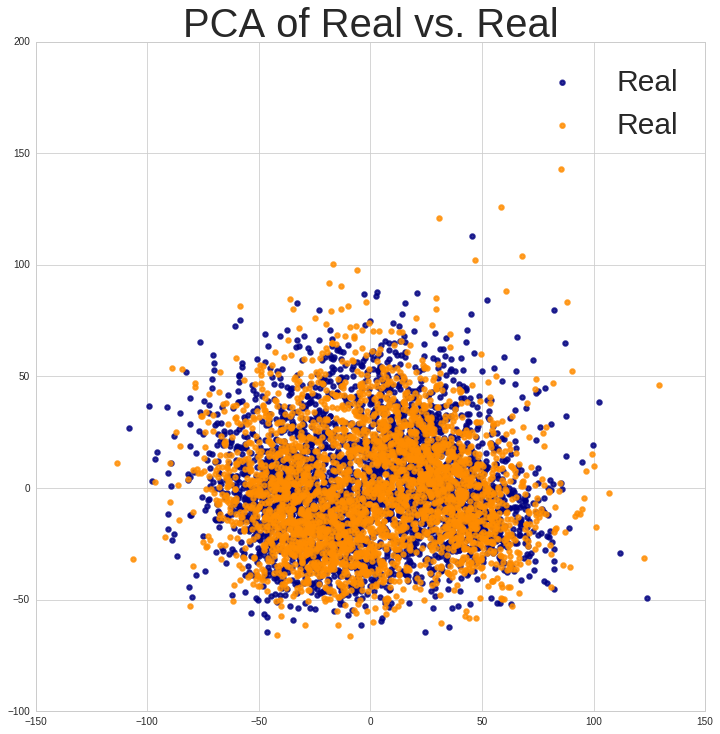

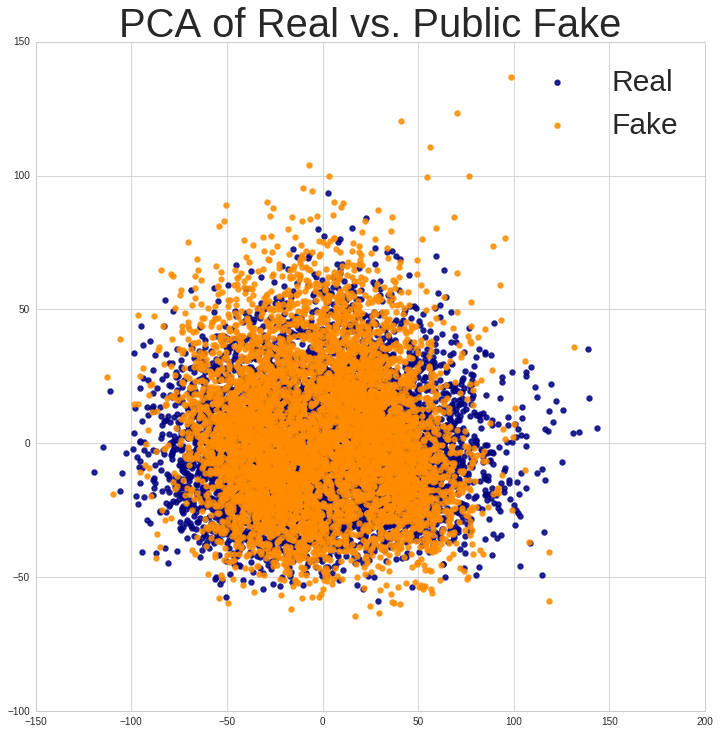

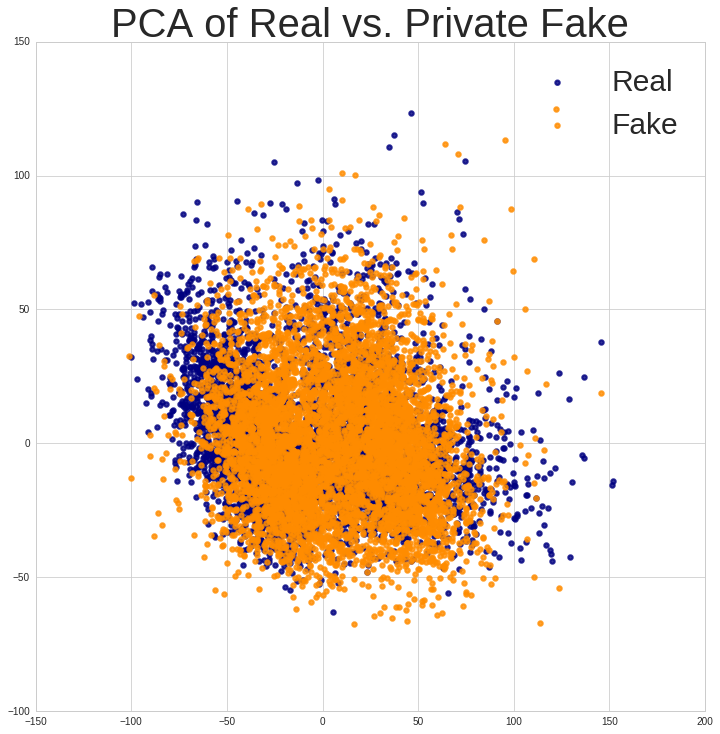

In [21]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 30,
          'axes.labelsize': 15,
          'axes.titlesize': 40,
          'xtick.labelsize':10,
          'ytick.labelsize':10}
pylab.rcParams.update(params)

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plt.figure(figsize=(12, 12))
X_pca = np.concatenate((X_train[:3000], X_train[3000:]))
print(X_pca.shape)

y = np.array([1] * 3000 + [0] * 3000)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Real', 'Real']
colors = ['navy', 'darkorange']
lw = 2

print(X_r.shape)
print(len(target_names))
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Real')

print(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 12))
X_pca = np.concatenate((X_train, X_public))
print(X_pca.shape)

y = np.array([1] * 6000 + [0] * 6000)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Real', 'Fake']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Public Fake')

print(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 12))
X_pca = np.concatenate((X_train, X_private))
print(X_pca.shape)

y = np.array([1] * 6000 + [0] * generate_count)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Real', 'Fake']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Private Fake')

print(pca.explained_variance_ratio_)